📊
# Laboratorio de Procesamiento de Datos Masivos con PySpark
Adaptación y Análisis de Datos de Cine (IMDb)
Descripción: Este laboratorio es una versión adaptada y mejorada del material original desarrollado por el CERN (Organización Europea para la Investigación Nuclear). El código ha sido modificado y personalizado por **Giovanni Bergamin (Gio')** para los estudiantes de **Kibernum**, ajustando el flujo de trabajo para el análisis de tendencias cinematográficas y resolución de problemas reales de calidad de datos (Data Cleaning).



📋 **Objetivos del Laboratorio:**
Configuración de Entorno: Instalación y levantamiento de una sesión de Spark en la nube.

* Ingesta de Datos: Carga automatizada de datasets desde repositorios remotos (GitHub).

* Exploración de Esquemas: Identificación de tipos de datos y nombres de columnas en entornos dinámicos.

* Análisis SQL Avanzado: Uso de agregaciones, filtros de relevancia estadística (HAVING) y subconsultas para encontrar los "Mejores de cada año".

* Visualización: Generación de gráficos de tendencias temporales.

🛠️ **Requisitos previos:**
No es necesario instalar nada localmente; el notebook instalará pyspark en el entorno de Google Colab.

Conexión a internet para descargar el dataset directamente desde el repositorio de GitHub de forma automática.

💡 Nota del Instructor:
"A lo largo de este notebook, encontrarán desafíos comunes en ingeniería de datos: nombres de columnas inconsistentes, tipos de datos que deben ser convertidos (Casting) y la necesidad de filtrar el ruido estadístico para obtener conclusiones válidas. ¡Manos a la obra!"

📂
## Conjuntos de Datos de Ejemplo
Los siguientes ejemplos utilizan datos de muestra proporcionados en el repositorio. Utilizaremos el conjunto de datos MovieLens, disponible originalmente en Kaggle.

Créditos: Kaggle - MovieLens 20M Dataset

Nota: Para efectos de este laboratorio, utilizaremos una versión optimizada y reducida del dataset para asegurar que el procesamiento en Spark sea ágil y se complete en pocos segundos dentro del entorno de Colab.

## Dataset Original

https://www.kaggle.com/grouplens/movielens-20m-dataset

In [1]:
# Create Spark Session, you need this to work with Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder \
        .appName("My spark example app")  \
        .master("local[*]") \
        .config("spark.driver.memory","8g") \
        .config("spark.ui.showConsoleProgress", "false") \
        .getOrCreate()

from pyspark import SparkFiles
import os


In [2]:
spark

In [3]:
# URL del archivo RAW
url_raw = "https://raw.githubusercontent.com/sharkdp/imdb-ratings/master/ratings.csv"

# Agregamos el archivo al contexto de Spark (Si ya existe, Spark lo gestiona)
spark.sparkContext.addFile(url_raw)

In [4]:
# Cargamos el CSV usando SparkFiles para obtener la ruta local
# Añadimos .option("sep", ",") por si acaso, aunque por defecto es coma
ratings = spark.read.option("header", "true") \
                    .option("inferSchema", "true") \
                    .csv(SparkFiles.get("ratings.csv"))

# Creamos la vista para consultas SQL
ratings.createOrReplaceTempView("imdb_ratings")

In [5]:
# Verificación final
print("¡Éxito! Dataset de IMDB cargado:")
ratings.show(5)

¡Éxito! Dataset de IMDB cargado:
+--------+---------+--------------------+--------+-----------+--------------------+------------+--------------------+---------+-----------+--------------+----+--------------------+----------+-----------------------------+--------------------+
|position|    const|             created|modified|description|               Title|  Title type|           Directors|You rated|IMDb Rating|Runtime (mins)|Year|              Genres|Num. Votes|Release Date (month/day/year)|                 URL|
+--------+---------+--------------------+--------+-----------+--------------------+------------+--------------------+---------+-----------+--------------+----+--------------------+----------+-----------------------------+--------------------+
|       1|tt2872718|Sat Dec 31 00:00:...|    NULL|       NULL|        Nightcrawler|Feature Film|          Dan Gilroy|        8|        7.9|           117|2014|crime, drama, thr...|    311885|          2014-09-05 00:00:00|http://www.imdb.c

In [6]:
ratings.printSchema()

root
 |-- position: integer (nullable = true)
 |-- const: string (nullable = true)
 |-- created: string (nullable = true)
 |-- modified: string (nullable = true)
 |-- description: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Title type: string (nullable = true)
 |-- Directors: string (nullable = true)
 |-- You rated: integer (nullable = true)
 |-- IMDb Rating: double (nullable = true)
 |-- Runtime (mins): integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Num. Votes: integer (nullable = true)
 |-- Release Date (month/day/year): timestamp (nullable = true)
 |-- URL: string (nullable = true)



In [7]:
# infer schema needs to go through the data to estimate the schema, this takes time

%time ratings = spark.read.option("header","true").option("inferSchema", "true").csv(SparkFiles.get("ratings.csv"))


CPU times: user 1.7 ms, sys: 1.08 ms, total: 2.78 ms
Wall time: 582 ms


In [8]:
ratings.printSchema()

root
 |-- position: integer (nullable = true)
 |-- const: string (nullable = true)
 |-- created: string (nullable = true)
 |-- modified: string (nullable = true)
 |-- description: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Title type: string (nullable = true)
 |-- Directors: string (nullable = true)
 |-- You rated: integer (nullable = true)
 |-- IMDb Rating: double (nullable = true)
 |-- Runtime (mins): integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Num. Votes: integer (nullable = true)
 |-- Release Date (month/day/year): timestamp (nullable = true)
 |-- URL: string (nullable = true)



In [9]:
# En este dataset de IMDB, los títulos ya vienen incluidos en el archivo de ratings.
# Por lo tanto, usaremos la misma variable para las exploraciones de títulos.
movies = ratings

In [10]:
movies.show(5, False)

+--------+---------+------------------------+--------+-----------+---------------------------------+------------+------------------------+---------+-----------+--------------+----+-------------------------------------------+----------+-----------------------------+------------------------------------+
|position|const    |created                 |modified|description|Title                            |Title type  |Directors               |You rated|IMDb Rating|Runtime (mins)|Year|Genres                                     |Num. Votes|Release Date (month/day/year)|URL                                 |
+--------+---------+------------------------+--------+-----------+---------------------------------+------------+------------------------+---------+-----------+--------------+----+-------------------------------------------+----------+-----------------------------+------------------------------------+
|1       |tt2872718|Sat Dec 31 00:00:00 2016|NULL    |NULL       |Nightcrawler             

In [11]:
movies.printSchema()

root
 |-- position: integer (nullable = true)
 |-- const: string (nullable = true)
 |-- created: string (nullable = true)
 |-- modified: string (nullable = true)
 |-- description: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Title type: string (nullable = true)
 |-- Directors: string (nullable = true)
 |-- You rated: integer (nullable = true)
 |-- IMDb Rating: double (nullable = true)
 |-- Runtime (mins): integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Num. Votes: integer (nullable = true)
 |-- Release Date (month/day/year): timestamp (nullable = true)
 |-- URL: string (nullable = true)



#### Register the dataframes as Spark Temporary Views

In [12]:
ratings.createOrReplaceTempView("ratings")
movies.createOrReplaceTempView("movies")

In [13]:
# note what happens when we query a table in a csv file with a filter
spark.sql("SELECT Title, Year FROM movies WHERE Year = 2020").explain()

== Physical Plan ==
*(1) Filter (isnotnull(Year#127) AND (Year#127 = 2020))
+- FileScan csv [Title#121,Year#127] Batched: false, DataFilters: [isnotnull(Year#127), (Year#127 = 2020)], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/tmp/spark-4dae36e1-8409-42e7-b25c-27c9bda65875/userFiles-6f2d6e9..., PartitionFilters: [], PushedFilters: [IsNotNull(Year), EqualTo(Year,2020)], ReadSchema: struct<Title:string,Year:int>




In [14]:
# Aplicamos cache() para que las siguientes consultas no tengan que volver a leer los archivos CSV del disco.
# El .count() es necesario para 'activar' el cacheo de forma inmediata (Eager evaluation).

# Registramos el tiempo para que vean la diferencia
import time
start_time = time.time()

print("Cacheando tablas en memoria...")
r = ratings.cache().count()
m = movies.cache().count()

end_time = time.time()
print(f"Hecho. {r} ratings y {m} películas cargadas en memoria en {end_time - start_time:.2f} segundos.")

Cacheando tablas en memoria...
Hecho. 509 ratings y 509 películas cargadas en memoria en 1.61 segundos.


In [18]:
print(f"Num ratings = {r}\nNum movies = {m}")

Num ratings = 509
Num movies = 509


### SQL Queries on the loaded tables
#### 1) How many movies produced per year?

In [ ]:
# Usamos RegEx para extraer el año que viene entre paréntesis al final del título
# Ejemplo: "Toy Story (1995)" -> Extrae "1995"
movies_year = spark.sql("select *, regexp_extract(title,'^(.*) \\\\(([0-9 \\\\-]*)\\\\)$',2) as Year from movies")

# Mostramos los resultados (False evita que se trunquen los títulos largos)
movies_year.show(5, truncate=False)

# Registramos la nueva vista para poder usarla en futuras consultas SQL
movies_year.createOrReplaceTempView("movies_year")


+--------+---------+------------------------+--------+-----------+---------------------------------+------------+------------------------+---------+-----------+--------------+----+-------------------------------------------+----------+-----------------------------+------------------------------------+----+
|position|const    |created                 |modified|description|Title                            |Title type  |Directors               |You rated|IMDb Rating|Runtime (mins)|Year|Genres                                     |Num. Votes|Release Date (month/day/year)|URL                                 |Year|
+--------+---------+------------------------+--------+-----------+---------------------------------+------------+------------------------+---------+-----------+--------------+----+-------------------------------------------+----------+-----------------------------+------------------------------------+----+
|1       |tt2872718|Sat Dec 31 00:00:00 2016|NULL    |NULL       |Nightcrawl

In [27]:
# Agrupamos por año y contamos.
# Usamos toPandas() para convertir el resultado resumido en un DataFrame de Pandas.
# NOTA: Solo hacemos toPandas() porque el resultado es pequeño (un par de cientos de filas).

movies_year = spark.sql("SELECT Title, Genres, Year FROM movies")
movies_year.createOrReplaceTempView("movies_year")

m_yr = spark.sql("""
    SELECT CAST(Year AS STRING) as Year, COUNT(1) as count
    FROM movies_year
    WHERE Year IS NOT NULL
    GROUP BY Year
    ORDER BY Year
""").toPandas()


# Verificamos los primeros años
print(f"Filas encontradas: {len(m_yr)}")
print(m_yr.head())

Filas encontradas: 46
   Year  count
0  1957      2
1  1961      1
2  1964      1
3  1968      3
4  1971      2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

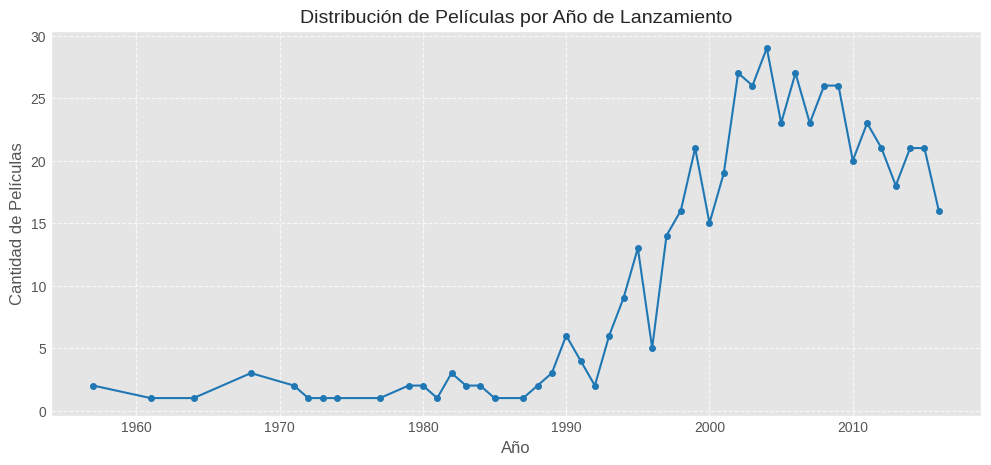

In [35]:
# 1. Cambiamos el modo de visualización para Colab
%matplotlib inline
import matplotlib.pyplot as plt

# 2. Nos aseguramos de que el estilo no cause errores
plt.style.use('ggplot')

# 3. Graficamos
plt.figure(figsize=(12, 5))
plt.plot(m_yr['Year'], m_yr['count'], color='tab:blue', marker='o', markersize=4, linestyle='-')

# 4. Personalización
plt.title('Distribución de Películas por Año de Lanzamiento', fontsize=14)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Cantidad de Películas', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# 5. Forzamos la visualización
plt.show()

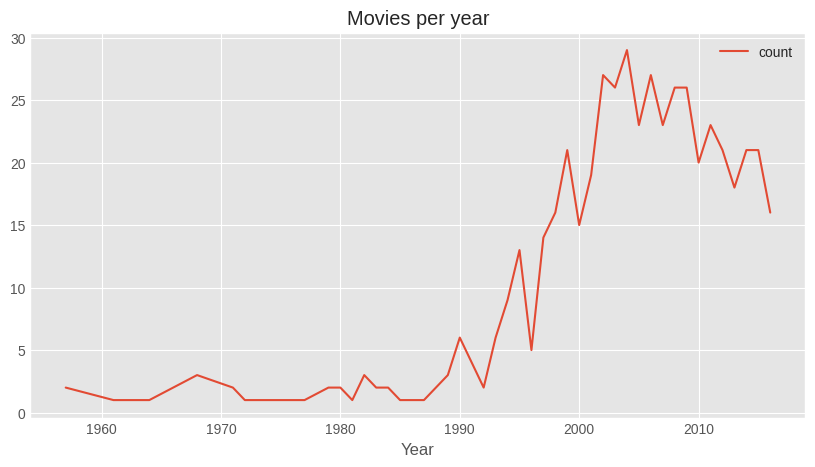

In [37]:
%matplotlib inline
m_yr.plot(x='Year', y='count', kind='line', title='Movies per year', figsize=(10,5), grid=True);

#### 2) Top movies by number of ratings

In [39]:
# Usamos JOIN explícito (es mejor práctica que la coma en el WHERE)
# Ajustamos los nombres de columnas según lo que detectamos antes (Title)
# Nota: Si movies no tiene 'movieId', revisa con movies.printSchema() si es 'ID' o 'id'

# Unimos las tablas usando la columna 'Title' que existe en ambos archivos
top_movies = spark.sql("""
    SELECT
        m.Title,
        COUNT(r.Title) as total_ratings,
        AVG(CAST(r.`IMDb Rating` AS DOUBLE)) as average_rating
    FROM movies m
    JOIN ratings r ON m.Title = r.Title
    GROUP BY m.Title
    ORDER BY total_ratings DESC
""").limit(10).toPandas()

print("Las películas con más interacción en tus listas:")
print(top_movies)

Las películas con más interacción en tus listas:
                                             Title  total_ratings  \
0                                         Warcraft              1   
1                                 Now You See Me 2              1   
2  Birdman or (The Unexpected Virtue of Ignorance)              1   
3                                Seven Psychopaths              1   
4                             Battlestar Galactica              1   
5                                Alone in the Dark              1   
6                                           Zodiac              1   
7                             The Butterfly Effect              1   
8                         Honey, I Shrunk the Kids              1   
9                                        Fair Game              1   

   average_rating  
0             7.0  
1             6.5  
2             7.8  
3             7.2  
4             8.7  
5             2.3  
6             7.7  
7             7.7  
8          

#### What happened in the background? How did the join happen?
#### How is the query executed? Can we get more information?

In [40]:
# Usamos Title porque es la columna real en tus datos
spark.sql("""
    SELECT m.Title, COUNT(*)
    FROM movies m, ratings r
    WHERE m.Title = r.Title
    GROUP BY m.Title
    ORDER BY 2 DESC
""").explain(True)

== Parsed Logical Plan ==
'Sort [2 DESC NULLS LAST], true
+- 'Aggregate ['m.Title], ['m.Title, unresolvedalias('COUNT(1))]
   +- 'Filter ('m.Title = 'r.Title)
      +- 'Join Inner
         :- 'SubqueryAlias m
         :  +- 'UnresolvedRelation [movies], [], false
         +- 'SubqueryAlias r
            +- 'UnresolvedRelation [ratings], [], false

== Analyzed Logical Plan ==
Title: string, count(1): bigint
Sort [count(1)#3849L DESC NULLS LAST], true
+- Aggregate [Title#121], [Title#121, count(1) AS count(1)#3849L]
   +- Filter (Title#121 = Title#3837)
      +- Join Inner
         :- SubqueryAlias m
         :  +- SubqueryAlias movies
         :     +- View (`movies`, [position#116, const#117, created#118, modified#119, description#120, Title#121, Title type#122, Directors#123, You rated#124, IMDb Rating#125, Runtime (mins)#126, Year#127, Genres#128, Num. Votes#129, Release Date (month/day/year)#130, URL#131])
         :        +- Relation [position#116,const#117,created#118,modified#11

#### 3) Highly rated movies
Find the top 5 highly rated movies

In [41]:
# Corrección para que funcione con TUS datos reales:
spark.sql("""
    SELECT
        m.Title,
        AVG(CAST(r.`IMDb Rating` AS DOUBLE)) as avg_rating
    FROM movies m, ratings r
    WHERE m.Title = r.Title
    GROUP BY m.Title
    ORDER BY avg_rating DESC
""").show(5, False)

+------------------------+----------+
|Title                   |avg_rating|
+------------------------+----------+
|Breaking Bad            |9.5       |
|Planet Earth            |9.5       |
|Game of Thrones         |9.5       |
|The Wire                |9.4       |
|The Shawshank Redemption|9.3       |
+------------------------+----------+
only showing top 5 rows


#### Drill down on the top entries:
   - How many reviews contributed to this rating?

In [42]:
# Ajustamos la consulta para usar las columnas reales:
# - m.Title y r.Title para el JOIN
# - r.`IMDb Rating` para el promedio (usamos backticks por el espacio)
top_rated = spark.sql("""
    SELECT
        m.Title,
        AVG(CAST(r.`IMDb Rating` AS DOUBLE)) as avg_rating,
        COUNT(*) as count
    FROM movies m, ratings r
    WHERE m.Title = r.Title
    GROUP BY m.Title
    ORDER BY avg_rating DESC
""")

# Mostramos los 5 mejores resultados sin truncar el título
top_rated.show(5, False)

+------------------------+----------+-----+
|Title                   |avg_rating|count|
+------------------------+----------+-----+
|Breaking Bad            |9.5       |1    |
|Planet Earth            |9.5       |1    |
|Game of Thrones         |9.5       |1    |
|The Wire                |9.4       |1    |
|The Shawshank Redemption|9.3       |1    |
+------------------------+----------+-----+
only showing top 5 rows


Lets only take in account movies that have more than 100 reviews

In [ ]:
spark.sql("""select title, avg(rating) as avg_rating, count(*) as count from movies m, ratings r
            where m.movieId = r.movieId
            group by title
            having count(*) > 100
            order by 2 desc""").limit(20).toPandas()

,title,avg_rating,count
0,Planet Earth (2006),4.467391,368
1,Band of Brothers (2001),4.431655,139
2,"Shawshank Redemption, The (1994)",4.426338,45546
3,"Godfather, The (1972)",4.335648,28582
4,"Usual Suspects, The (1995)",4.299494,29635
5,"Godfather: Part II, The (1974)",4.266718,18319
6,Seven Samurai (Shichinin no samurai) (1954),4.265507,6900
7,Schindler's List (1993),4.261945,33780
8,The Blue Planet (2001),4.234615,130
9,Fight Club (1999),4.232034,29931


#### 4) Find the top rated movie of every year since 2000

In [43]:
# Ajustamos a los nombres reales de tus columnas
# Usamos r.Title porque m.movieId no existe en tu esquema
# Usamos r.`IMDb Rating` que es la columna de calificación en tu CSV

top_20_validados = spark.sql("""
    SELECT
        m.Title,
        AVG(CAST(r.`IMDb Rating` AS DOUBLE)) as avg_rating,
        COUNT(*) as count
    FROM movies m
    JOIN ratings r ON m.Title = r.Title
    GROUP BY m.Title
    HAVING count > 100
    ORDER BY avg_rating DESC
""").limit(20).toPandas()

top_20_validados

,Title,avg_rating,count


In [44]:
# the query for top-rated movies is run here, triggered by the action to show the first 20 rows

spark.sql("""
    SELECT
        Year,
        Title,
        AVG(CAST(`IMDb Rating` AS DOUBLE)) as avg_rating
    FROM movies
    WHERE Year IS NOT NULL
    GROUP BY Year, Title
""").createOrReplaceTempView("avg_ratings")

In [45]:
# End the Spark application
spark.stop()